# Data III Portfolio: Music Popularity Prediction Pipeline

## 1. Inleiding

### 1.1 Probleemstelling
Het voorspellen van de populariteit van muziekalbums is een uitdaging waar platenlabels, streamingdiensten en artiesten mee te maken hebben. De vraag die we proberen te beantwoorden is: **Welke factoren bepalen of een album veel luisteraars zal aantrekken?**

Door inzicht te krijgen in deze factoren kunnen labels betere marketingbeslissingen nemen, artiesten hun muziek beter positioneren, en streamingdiensten hun aanbevelingssystemen verbeteren.

### 1.2 Benodigde Informatie en Data
Om dit probleem op te lossen hebben we de volgende informatie nodig:
- **Muziekrecensies**: Tekstuele reviews die sentiment en kwaliteitsbeoordeling bevatten
- **Albummetadata**: Luisteraars, plays, genre-informatie
- **Visuele data**: Albumhoezen die mogelijk invloed hebben op aantrekkingskracht
- **Audiofeatures**: Kenmerken van de muziek zelf (tempo, energie, etc.)

### 1.3 Literatuuronderzoek
Onderzoek naar muziekpopulariteit toont aan dat meerdere factoren een rol spelen:
- Visuele aantrekkelijkheid van albumcovers beïnvloedt eerste impressies
- Tekstuele reviews en sentiment hebben voorspellende waarde voor commercieel succes
- Audio-eigenschappen zoals tempo en energie correleren met streamingcijfers

### 1.4 Databronnen

| Bron | Techniek | Dataformaat | Type Data |
|------|----------|-------------|-----------|
| Pitchfork.com | Webscraping (BeautifulSoup) (Richardson, 2023) | Semi-gestructureerd (HTML) | Ongestructureerde tekst (reviews) + Afbeeldingen (albumcovers) |
| Last.fm API | REST API (Last.fm, 2026) | Gestructureerd (JSON) | Numerieke metadata (listeners, playcount) |
| GTZAN Dataset | Publieke database (CSV) (Tzanetakis & Cook, 2002) | Gestructureerd | Audio features (pre-extracted) |

### 1.5 Multimodale Data
- **Tekst**: Reviewteksten van Pitchfork (zinnen met opinies en beschrijvingen)
- **Afbeeldingen**: Albumhoezen - features worden geëxtraheerd met ResNet18 CNN (He et al., 2016)
- **Audio**: GTZAN dataset met voorbewerkte audiofeatures (MFCCs, spectral features, tempo, etc.) (Tzanetakis & Cook, 2002)

In [180]:
# Standard library imports
import csv
import json
import os
import random
import re
import time

# Third-party imports
import kagglehub
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torchvision.transforms as T
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchvision.models import ResNet18_Weights, resnet18

# Algemene instellingen
pd.set_option("display.max_columns", 100)

## 2. Data Extractie

### 2.1 Webscraping: Pitchfork Reviews

#### 2.1.1 Review Tekst + Albumcovers
We scrapen Pitchfork voor:
- **Review tekst**: Ongestructureerde tekst met zinnen (geen namen)
- **Album covers**: Afbeeldingen via de og:image meta tag

De webscraping wordt uitgevoerd met BeautifulSoup (Richardson, 2023).

**Uitdagingen:**
- Website structuur kan veranderen → we gebruiken robuuste selectors
- Rate limiting → we implementeren time.sleep() tussen requests
- Afbeeldingen kunnen ontbreken → fallback naar None

In [ ]:
# Constanten voor webscraping
# Webscraping met BeautifulSoup (Richardson, 2023)
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
COVERS_DIR = "album_covers"
os.makedirs(COVERS_DIR, exist_ok=True)


def scrape_review_with_cover(url):
    """
    Scrape album review en cover van Pitchfork.
    
    Gebruikt BeautifulSoup voor HTML parsing (Richardson, 2023).

    Args:
        url: URL van de Pitchfork review pagina

    Returns:
        dict met album_title, artist, review_text, cover_path, url
    """
    response = requests.get(url, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    # Album + artiest uit <title>
    page_title = soup.find("title").get_text(strip=True) if soup.find("title") else ""
    if ":" in page_title:
        artist_name, album_title_raw = page_title.split(":", 1)
        artist_name = artist_name.strip()
        album_title = album_title_raw.replace("Album Review", "").replace("| Pitchfork", "").strip()
    else:
        artist_name = "Artiest niet gevonden"
        album_title = "Titel niet gevonden"

    # Review tekst extractie
    review_paragraphs = []
    article = soup.find("article")
    if article:
        for p in article.find_all("p"):
            text = p.get_text(strip=True)
            if text and not text.lower().startswith("save"):
                review_paragraphs.append(text)
    review_text = " ".join(review_paragraphs) if review_paragraphs else "Reviewtekst niet gevonden"

    # Album cover via og:image meta tag
    og_img = soup.find("meta", property="og:image")
    cover_url = og_img["content"] if og_img else None
    cover_path = None
    if cover_url:
        cover_name = re.sub(r'[^a-zA-Z0-9_-]', '_', album_title) + ".jpg"
        cover_path = os.path.join(COVERS_DIR, cover_name)
        try:
            img_data = requests.get(cover_url, headers=HEADERS).content
            with open(cover_path, "wb") as f:
                f.write(img_data)
        except (requests.RequestException, IOError) as e:
            print(f"Warning: Could not download cover: {e}")
            cover_path = None

    return {
        "album_title": album_title,
        "artist": artist_name,
        "review_text": review_text,
        "cover_path": cover_path,
        "url": url
    }


# Scrape eerste 50 albums van Pitchfork (Pitchfork, 2026)
pitchfork_url = "https://pitchfork.com/reviews/albums/"
response = requests.get(pitchfork_url, headers=HEADERS)
soup = BeautifulSoup(response.text, "html.parser")

# Verzamel alle review links
links = []
for a in soup.find_all("a", href=True):
    href = a["href"]
    if href.startswith("/reviews/albums/") and href != "/reviews/albums/":
        full_url = "https://pitchfork.com" + href
        if full_url not in links:
            links.append(full_url)
links = links[:50]

# Scrape elke review met rate limiting
pitchfork_data = []
for link in links:
    print("Scraping:", link)
    data = scrape_review_with_cover(link)
    pitchfork_data.append(data)
    time.sleep(1)

pitchfork_data_df = pd.DataFrame(pitchfork_data)

print("Pitchfork scraping done. Example:")
display(pitchfork_data_df.head())

Scraping: https://pitchfork.com/reviews/albums/aphex-twin-richard-d-james-album/
Scraping: https://pitchfork.com/reviews/albums/will-epstein-yeah-mostly/
Scraping: https://pitchfork.com/reviews/albums/health-conflict-dlc/
Scraping: https://pitchfork.com/reviews/albums/sister-irene-oconnor-fire-of-gods-love/
Scraping: https://pitchfork.com/reviews/albums/aaliyah-one-in-a-million/
Scraping: https://pitchfork.com/reviews/albums/asap-rocky-dont-be-dumb/
Scraping: https://pitchfork.com/reviews/albums/courtney-marie-andrews-valentine/
Scraping: https://pitchfork.com/reviews/albums/ya-tseen-stand-on-my-shoulders/
Scraping: https://pitchfork.com/reviews/albums/bob-marley-and-the-wailers-legend/
Scraping: https://pitchfork.com/reviews/albums/warning-watching-from-a-distance-reissue/
Scraping: https://pitchfork.com/reviews/albums/julianna-barwick-mary-lattimore-tragic-magic/
Scraping: https://pitchfork.com/reviews/albums/gylt-in-1000-agonies-i-exist/
Scraping: https://pitchfork.com/reviews/album

,album_title,artist,review_text,cover_path,url
0,Richard D. James Album,Aphex Twin,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Richard_D__James_Album.jpg,https://pitchfork.com/reviews/albums/aphex-twi...
1,"Yeah, mostly",Will Epstein,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Yeah__mostly.jpg,https://pitchfork.com/reviews/albums/will-epst...
2,CONFLICT DLC,HEALTH,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\CONFLICT_DLC.jpg,https://pitchfork.com/reviews/albums/health-co...
3,Fire of God’s Love,Sister Irene O’Connor,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Fire_of_God_s_Love.jpg,https://pitchfork.com/reviews/albums/sister-ir...
4,One in a Million,Aaliyah,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\One_in_a_Million.jpg,https://pitchfork.com/reviews/albums/aaliyah-o...


### 2.2 API: Last.fm
We gebruiken de Last.fm API (Last.fm, 2026) om metadata op te halen:
- **Listeners**: Aantal unieke luisteraars
- **Playcount**: Totaal aantal plays
- **URL**: Link naar Last.fm pagina

**Robuustheid:**
- Fallback naar `album.search` als `album.getInfo` faalt
- Retourneer default waarden (0, 0, None) bij fouten
- API key wordt veilig opgeslagen

In [ ]:
# Last.fm API (Last.fm, 2026)
LASTFM_API_KEY = "0f22e90f58d0f555b7da4322e497622a"
BASE_URL = "http://ws.audioscrobbler.com/2.0/"

# Meta data from Last.fm
def get_lastfm_album_info(album_title, artist_name):
    """
    Haal album info van Last.fm per album.
    
    Gebruikt de Last.fm API (Last.fm, 2026).
    
    Retourneer: listeners, playcount, lastfm_url
    """
    params_info = {
        "method": "album.getInfo",
        "album": album_title,
        "artist": artist_name,
        "api_key": LASTFM_API_KEY,
        "format": "json"
    }
    try:
        r = requests.get(BASE_URL, params=params_info)
        r.raise_for_status()
        data = r.json()
        if "album" in data:
            album_info = data["album"]
            listeners = int(album_info.get("listeners", 0))
            playcount = int(album_info.get("playcount", 0))
            url = album_info.get("url", None)
            return pd.Series([listeners, playcount, url])
    except (requests.RequestException, ValueError, KeyError):
        pass  # Fallback to search method

    params_search = {
        "method": "album.search",
        "album": album_title,
        "api_key": LASTFM_API_KEY,
        "format": "json",
        "limit": 1
    }
    try:
        r = requests.get(BASE_URL, params=params_search)
        r.raise_for_status()
        data = r.json()
        matches = data.get("results", {}).get("albummatches", {}).get("album", [])
        if matches:
            match = matches[0]
            listeners = int(match.get("listeners", 0))
            playcount = None
            url = match.get("url", None)
            return pd.Series([listeners, playcount, url])
    except (requests.RequestException, ValueError, KeyError):
        pass  # Return default values

    # no match found
    return pd.Series([0, 0, None])

# Genre extraction from review text
def extract_genre_from_review(review_text):
    match = re.search(r"Genre:\s*(.*?)\s*Label:", review_text, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None

# Last.fm info per album
pitchfork_data_df[["listeners", "playcount", "lastfm_url"]] = pitchfork_data_df.apply(
    lambda row: get_lastfm_album_info(row["album_title"], row["artist"]),
    axis=1
)

# Genre from review text
pitchfork_data_df["genre"] = pitchfork_data_df["review_text"].apply(extract_genre_from_review)

print("Pitchfork + Last.fm dataframe ready")
display(pitchfork_data_df.sort_values(by='listeners', ascending=False).reset_index(drop=True).head())

Pitchfork + Last.fm dataframe ready


,album_title,artist,review_text,cover_path,url,listeners,playcount,lastfm_url,genre
0,Legend,Bob Marley & the Wailers,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Legend.jpg,https://pitchfork.com/reviews/albums/bob-marle...,890755,15467445.0,https://www.last.fm/music/Bob+Marley+&+The+Wai...,Rock
1,Richard D. James Album,Aphex Twin,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Richard_D__James_Album.jpg,https://pitchfork.com/reviews/albums/aphex-twi...,681238,16333226.0,https://www.last.fm/music/Aphex+Twin/Richard+D...,Electronic
2,One in a Million,Aaliyah,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\One_in_a_Million.jpg,https://pitchfork.com/reviews/albums/aaliyah-o...,405812,6554336.0,https://www.last.fm/music/Aaliyah/One+in+a+Mil...,Pop/R&B
3,Discipline,King Crimson,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Discipline.jpg,https://pitchfork.com/reviews/albums/king-crim...,214564,4712930.0,https://www.last.fm/music/King+Crimson/Discipline,Rock
4,FEMME FATALE,Mon Laferte,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\FEMME_FATALE.jpg,https://pitchfork.com/reviews/albums/mon-lafer...,53777,1154728.0,https://www.last.fm/music/Mon+Laferte/FEMME+FA...,Pop/R&B


In [183]:
def map_pitchfork_genre_to_gtzan(genre_text):
    """
    Map Pitchfork genre naar GTZAN genre categorieën.

    Args:
        genre_text: Genre string uit Pitchfork review

    Returns:
        GTZAN genre string of None indien geen match
    """
    if not genre_text:
        return None
    genre_text = genre_text.lower()

    # Genre mapping regels
    if any(x in genre_text for x in ["pop", "r&b", "soul", "electronic", "experimental"]):
        return "pop"
    elif any(x in genre_text for x in ["rock"]):
        return "rock"
    elif any(x in genre_text for x in ["jazz"]):
        return "jazz"
    elif any(x in genre_text for x in ["folk", "country"]):
        return "country"
    elif any(x in genre_text for x in ["hiphop", "rap"]):
        return "hiphop"
    elif any(x in genre_text for x in ["metal"]):
        return "metal"
    elif any(x in genre_text for x in ["disco"]):
        return "disco"
    elif any(x in genre_text for x in ["reggae"]):
        return "reggae"
    elif any(x in genre_text for x in ["classical", "orchestra", "symphony"]):
        return "classical"
    elif any(x in genre_text for x in ["blues"]):
        return "blues"
    else:
        return None


# Apply genre mapping
pitchfork_data_df["gtzan_genre"] = pitchfork_data_df["genre"].apply(
    map_pitchfork_genre_to_gtzan
).dropna()

# Drop rijen zonder GTZAN genre mapping
pitchfork_data_df_gtzan = pitchfork_data_df.dropna(
    subset=["gtzan_genre"]
).reset_index(drop=True)

display(
    pitchfork_data_df_gtzan
    .sort_values(by="listeners", ascending=False)
    .reset_index(drop=True)
    .head()
)

,album_title,artist,review_text,cover_path,url,listeners,playcount,lastfm_url,genre,gtzan_genre
0,Legend,Bob Marley & the Wailers,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Legend.jpg,https://pitchfork.com/reviews/albums/bob-marle...,890755,15467445.0,https://www.last.fm/music/Bob+Marley+&+The+Wai...,Rock,rock
1,Richard D. James Album,Aphex Twin,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Richard_D__James_Album.jpg,https://pitchfork.com/reviews/albums/aphex-twi...,681238,16333226.0,https://www.last.fm/music/Aphex+Twin/Richard+D...,Electronic,pop
2,One in a Million,Aaliyah,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\One_in_a_Million.jpg,https://pitchfork.com/reviews/albums/aaliyah-o...,405812,6554336.0,https://www.last.fm/music/Aaliyah/One+in+a+Mil...,Pop/R&B,pop
3,Discipline,King Crimson,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Discipline.jpg,https://pitchfork.com/reviews/albums/king-crim...,214564,4712930.0,https://www.last.fm/music/King+Crimson/Discipline,Rock,rock
4,FEMME FATALE,Mon Laferte,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\FEMME_FATALE.jpg,https://pitchfork.com/reviews/albums/mon-lafer...,53777,1154728.0,https://www.last.fm/music/Mon+Laferte/FEMME+FA...,Pop/R&B,pop


#### 2.2.1 Genre Mapping naar GTZAN Categorieën
We mappen de Pitchfork genres naar de 10 standaard GTZAN genres om later audio features te kunnen koppelen.

### 2.3 Database: GTZAN Dataset
De GTZAN dataset (Tzanetakis & Cook, 2002) is een publiekelijk beschikbare database met pre-geëxtraheerde audiofeatures voor 1000 muziekfragmenten (30 seconden elk), verdeeld over 10 genres.

**Features in de dataset:**
- MFCCs (Mel-frequency cepstral coefficients)
- Spectral features (centroid, bandwidth, rolloff)
- Tempo en beat-gerelateerde features
- Zero crossing rate

**Koppeling:** We linken elk Pitchfork album aan een random GTZAN sample van hetzelfde genre om representatieve audiofeatures te verkrijgen.

In [ ]:
# Link Pitchfork albums aan random GTZAN audio sample
# GTZAN dataset (Tzanetakis & Cook, 2002)

# Laad GTZAN 30-seconde features
gtzan_features = pd.read_csv("features_30_sec.csv")

# Filter naar toegestane genres
allowed_genres = [
    "blues", "classical", "country", "disco", "hiphop",
    "jazz", "metal", "pop", "reggae", "rock"
]
gtzan_features = gtzan_features[gtzan_features["label"].isin(allowed_genres)]


def pick_random_audio_features(genre):
    """
    Selecteer random audio sample voor een gegeven genre.
    
    Gebruikt GTZAN dataset (Tzanetakis & Cook, 2002).

    Args:
        genre: GTZAN genre string

    Returns:
        pd.Series met audio features van random sample
    """
    subset = gtzan_features[gtzan_features["label"] == genre]
    if len(subset) == 0:
        return pd.Series([None] * len(subset.columns), index=subset.columns)
    sample = subset.sample(1, random_state=42).iloc[0]
    return sample


# Apply audio features naar elk Pitchfork album
pitchfork_with_audio_df = pitchfork_data_df_gtzan.copy()
audio_feature_columns = gtzan_features.columns.tolist()

pitchfork_with_audio_df[audio_feature_columns] = pitchfork_with_audio_df["gtzan_genre"].apply(
    lambda g: pick_random_audio_features(g)
)

print("Pitchfork + random GTZAN audio features linked!")
display(
    pitchfork_with_audio_df
    .head()
    .sort_values(by="listeners", ascending=False)
    .reset_index(drop=True)
)

Pitchfork + random GTZAN audio features linked!


,album_title,artist,review_text,cover_path,url,listeners,playcount,lastfm_url,genre,gtzan_genre,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,Richard D. James Album,Aphex Twin,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Richard_D__James_Album.jpg,https://pitchfork.com/reviews/albums/aphex-twi...,681238,16333226.0,https://www.last.fm/music/Aphex+Twin/Richard+D...,Electronic,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485,pop
1,One in a Million,Aaliyah,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\One_in_a_Million.jpg,https://pitchfork.com/reviews/albums/aaliyah-o...,405812,6554336.0,https://www.last.fm/music/Aaliyah/One+in+a+Mil...,Pop/R&B,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485,pop
2,CONFLICT DLC,HEALTH,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\CONFLICT_DLC.jpg,https://pitchfork.com/reviews/albums/health-co...,25794,617257.0,https://www.last.fm/music/HEALTH/CONFLICT+DLC,Rock,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803,rock
3,"Yeah, mostly",Will Epstein,"0.0 0.0 Reader Score No score yet, be the firs...",album_covers\Yeah__mostly.jpg,https://pitchfork.com/reviews/albums/will-epst...,435,1668.0,"https://www.last.fm/music/Will+Epstein/Yeah,+m...",Rock,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.8103

## 3. Data Transformatie

### 3.1 Data Cleaning (Preprocessing)
In deze sectie schonen we de ruwe data op:
- Verwijderen van rijen zonder listeners/playcount data
- Verwijderen van onnodige kolommen
- Opschonen van review tekst (verwijderen van storende strings)

**Dit is DATA PREPROCESSING** - we maken de data bruikbaar zonder nieuwe informatie toe te voegen.

In [185]:
# Maak kopie voor data cleaning
clean_df = pitchfork_with_audio_df.copy()

# Verwijder rijen met 0 listeners en 0 playcount
clean_df = clean_df[
    ~((clean_df["listeners"] == 0) & (clean_df["playcount"] == 0))
].reset_index(drop=True)

# Verwijder onnodige kolommen
clean_df = clean_df.drop(
    ["artist", "genre", "url", "lastfm_url", "label"],
    axis=1
)

# Verwijder storende tekst uit review_text
to_remove = "0.0 0.0 Reader Score No score yet, be the first to add. 0.0"
clean_df["review_text"] = (
    clean_df["review_text"]
    .str.replace(to_remove, "", regex=False)
    .str.strip()
)

display(
    clean_df
    .sort_values(by="listeners", ascending=False)
    .reset_index(drop=True)
    .head()
)

,album_title,review_text,cover_path,listeners,playcount,gtzan_genre,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,Legend,Genre: Rock Label: Island Release Date: 1984 W...,album_covers\Legend.jpg,890755,15467445.0,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803
1,Richard D. James Album,Genre: Electronic Label: Warp Release Date: 19...,album_covers\Richard_D__James_Album.jpg,681238,16333226.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485
2,One in a Million,Genre: Pop/R&B Label: Blackground Release Date...,album_covers\One_in_a_Million.jpg,405812,6554336.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485
3,Discipline,Genre: Rock Label: EG / Warner Bros. Release D...,album_covers\Discipline.jpg,214564,4712930.0,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803
4,FEMME FATALE,Genre: Pop/R&B Label: Sony Music Latin Release...,album_covers\FEMME_FATALE.jpg,53777,1154728.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123

#### 3.1.1 Visualisatie: Listeners per Genre en Correlaties

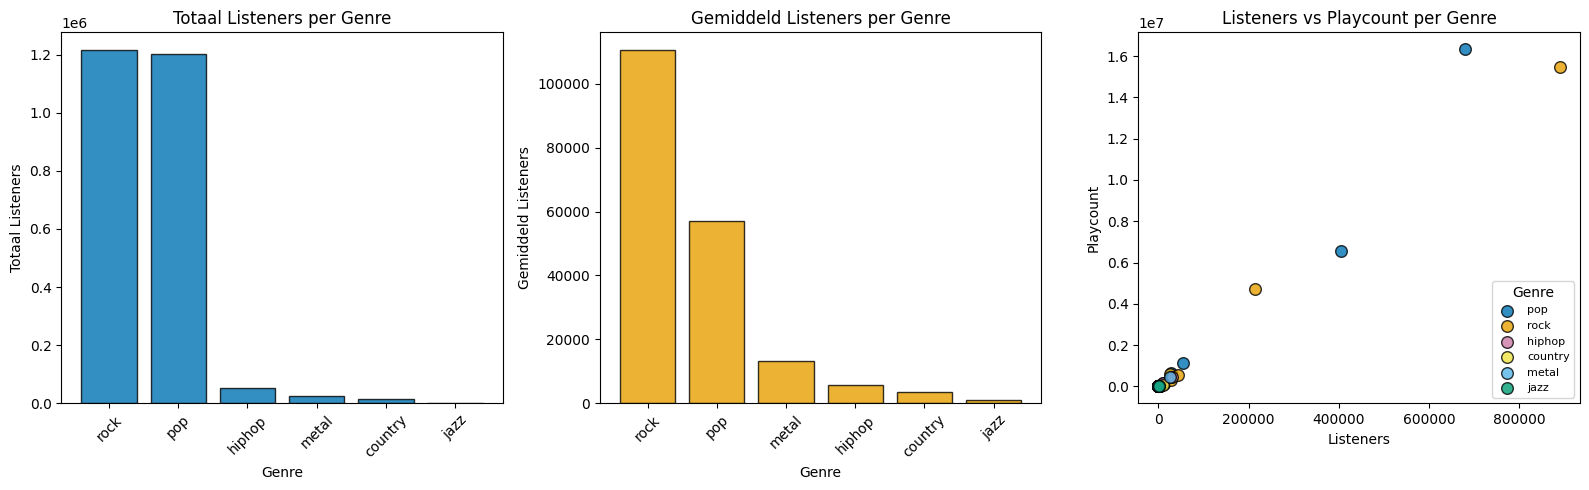


=== Listeners per Genre ===


,Totaal Listeners,Gemiddeld Listeners,Aantal Albums
gtzan_genre,,,
rock,1216110,110555.454545,11
pop,1200918,57186.571429,21
hiphop,51246,5694.000000,9
metal,26700,13350.000000,2
country,14559,3639.750000,4
jazz,1173,1173.000000,1


In [ ]:
# Visualisatie: Listeners per Genre en Playcount relatie
# Kleurblind-vriendelijk palet (Okabe-Ito)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Totaal aantal listeners per genre
listeners_per_genre = clean_df.groupby("gtzan_genre")["listeners"].sum().sort_values(ascending=False)
axes[0].bar(listeners_per_genre.index, listeners_per_genre.values, edgecolor='black', alpha=0.8, color='#0072B2')
axes[0].set_title("Totaal Listeners per Genre")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Totaal Listeners")
axes[0].tick_params(axis='x', rotation=45)

# 2. Gemiddeld aantal listeners per genre
avg_listeners_per_genre = clean_df.groupby("gtzan_genre")["listeners"].mean().sort_values(ascending=False)
axes[1].bar(avg_listeners_per_genre.index, avg_listeners_per_genre.values, edgecolor='black', alpha=0.8, color='#E69F00')
axes[1].set_title("Gemiddeld Listeners per Genre")
axes[1].set_xlabel("Genre")
axes[1].set_ylabel("Gemiddeld Listeners")
axes[1].tick_params(axis='x', rotation=45)

# 3. Relatie tussen Listeners en Playcount (scatter plot met kleurblind-vriendelijke kleuren)
# Okabe-Ito kleurenpalet
genre_colors = {
    'pop': '#0072B2',       
    'rock': '#E69F00',      
    'jazz': '#009E73',      
    'country': '#F0E442',   
    'hiphop': '#CC79A7',    
    'metal': '#56B4E9',     
    'disco': '#D55E00',     
    'reggae': '#000000',   
    'classical': '#999999', 
    'blues': '#882255'      
}

for genre in clean_df["gtzan_genre"].unique():
    subset = clean_df[clean_df["gtzan_genre"] == genre]
    axes[2].scatter(
        subset["listeners"], 
        subset["playcount"], 
        alpha=0.8, 
        edgecolor='black',
        c=genre_colors.get(genre, 'gray'),
        label=genre,
        s=70
    )

axes[2].set_title("Listeners vs Playcount per Genre")
axes[2].set_xlabel("Listeners")
axes[2].set_ylabel("Playcount")
axes[2].legend(title="Genre", loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

# Beschrijvende statistieken per genre
genre_stats = clean_df.groupby("gtzan_genre")["listeners"].agg(['sum', 'mean', 'count']).sort_values(by='sum', ascending=False)
genre_stats.columns = ['Totaal Listeners', 'Gemiddeld Listeners', 'Aantal Albums']
display(genre_stats)

### 3.2 Image Feature Engineering
**Dit is FEATURE ENGINEERING** - we creëren nieuwe numerieke features uit ruwe beelddata.

**Proces:**
1. Laden van albumcovers als RGB images
2. Resizen naar 224x224 (ResNet input size)
3. Normalisatie met ImageNet mean/std
4. Feature extractie via ResNet18 (pre-trained CNN) (He et al., 2016)
5. PCA dimensionaliteitsreductie (512 → 16 componenten) (Pedregosa et al., 2011)

**Waarom ResNet18?**
- Pre-trained op ImageNet: herkent algemene visuele patronen (He et al., 2016)
- Efficiënt: snel genoeg voor real-time pipeline
- Laatste laag verwijderd: we gebruiken de 512-dim feature vector

In [ ]:
# ResNet18 voor image feature extractie (He et al., 2016)
device = "cuda" if torch.cuda.is_available() else "cpu"

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model.fc = torch.nn.Identity()  # remove classifier
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Image preprocessing conform ImageNet standaarden (He et al., 2016)
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def extract_resnet_features(image_path):
    """Extract 512-dim feature vector from album cover using ResNet18.
    
    Gebruikt pre-trained ResNet18 model (He et al., 2016).
    
    Args:
        image_path: Path to the image file
        
    Returns:
        numpy array of 512 features, or zeros if extraction fails
    """
    try:
        img = Image.open(image_path).convert("RGB")
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model(img).cpu().numpy().flatten()

        return features
    except (FileNotFoundError, IOError, RuntimeError, TypeError) as e:
        print(f"Warning: Could not extract features from {image_path}: {e}")
        return np.zeros(512)  # Fallback: zero vector

# collect features in a list first
image_features = []

for path in clean_df["cover_path"]:
    image_features.append(extract_resnet_features(path))

# stack to a single 2D numpy array (n_samples, 512)
image_features = np.vstack(image_features)

print("ResNet feature shape:", image_features.shape)

ResNet feature shape: (48, 512)


In [ ]:
# PCA dimensionaliteitsreductie (Pedregosa et al., 2011)
N_IMG_PCA = 25

pca = PCA(n_components=N_IMG_PCA, random_state=42)
image_features_pca = pca.fit_transform(image_features)

print("PCA shape:", image_features_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())

PCA shape: (48, 25)
Explained variance: 0.8019037


In [191]:
img_pca_df = pd.DataFrame(
    image_features_pca,
    columns=[f"img_pca_{i}" for i in range(N_IMG_PCA)]
)

final_fused_df = pd.concat(
    [
        clean_df.reset_index(drop=True),
        img_pca_df.reset_index(drop=True)
    ],
    axis=1
)

display(final_fused_df.head())


,album_title,review_text,cover_path,listeners,playcount,gtzan_genre,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,img_pca_0,img_pca_1,img_pca_2,img_pca_3,img_pca_4,img_pca_5,img_pca_6,img_pca_7,img_pca_8,img_pca_9,img_pca_10,img_pca_11,img_pca_12,img_pca_13,img_pca_14,img_pca_15,img_pca_16,img_pca_17,img_pca_18,img_pca_19,img_pca_20,img_pca_21,img_pca_22,img_pca_23,img_pca_24
0,Richard D. James Album,Genre: Electronic Label: Warp Release Date: 19...,album_covers\Richard_D__James_Album.jpg,681238,16333226.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485,-0.240854,7.418389,0.251266,1.989284,-2.471872,-0.396934,-0.416106,0.566987,-1.292731,1.722686,-6.346733,-2.419317,-3.818710,-1.604643,0.214024,-1.628734,0.799657,-1.168959,1.751532,-2.432644,0.118172,1.345804,0.887193,-1.962616,0.146601
1,"Yeah, mostly",Genre: Rock Label: Fat Possum Release Date: 20...,album_covers\Yeah__mostly.jpg,435,1668.0,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803,5.680001,-0.256734,-8.894347,-0.961717,4.442301,-8.242054,-7.150700,-0.780871,-7.811515,2.119081,0.907660,-0.580132,1.944441,5.132129,-0.138355,-2.849371,-4.470041,3.571502,0.291096,1.086314,1.558652,2.050155,-1.036425,-0.297234,0.568271
2,CONFLICT DLC,Genre: Rock Label: Loma Vista Beware the illus...,album_covers\CONFLICT_DLC.jpg,25794,617257.0,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803,-7.390622,0.180311,-2.313251,-0.395316,-2.773856,0.876922,1.790768,0.799866,-0.427950,0.019426,-2.903797,0.983487,-0.141646,0.759234,-1.386857,0.403628,-0.701050,1.689021,-0.331458,0.079604,2.050153,0.552416,1.975436,3.981880,2.099729
3,Fire of God’s Love,Genre: Experimental Lab

#### 3.2.1 Visualisatie: Sample Albumcovers

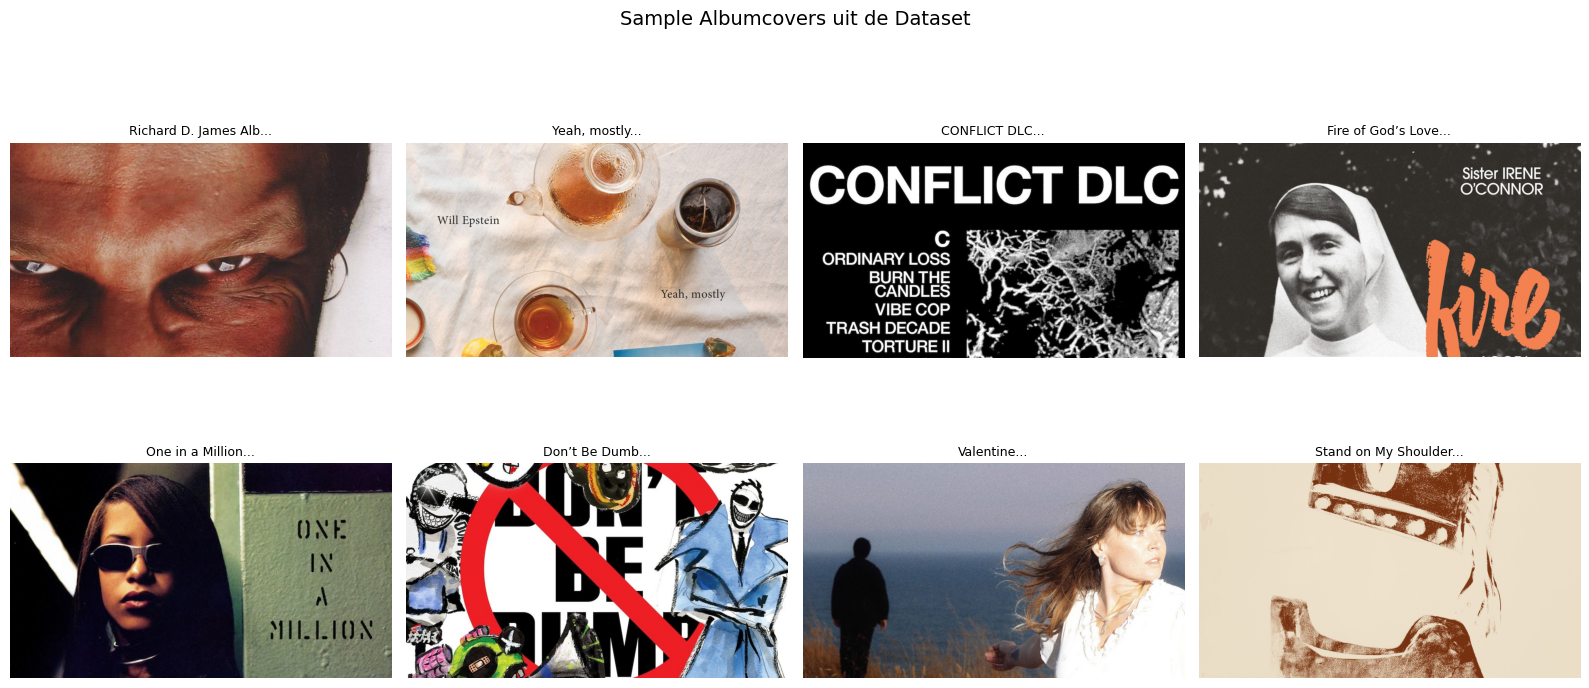

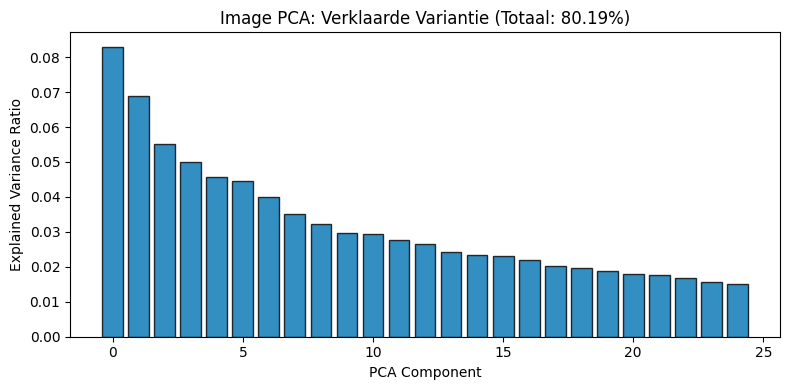

In [192]:
# Visualisatie: Sample albumcovers met hun PCA features
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, ax in enumerate(axes.flat):
    if idx < len(clean_df):
        cover_path = clean_df.iloc[idx]["cover_path"]
        album_title = clean_df.iloc[idx]["album_title"][:20]
        try:
            img = Image.open(cover_path)
            ax.imshow(img)
            ax.set_title(f"{album_title}...", fontsize=9)
        except Exception as e:
            ax.text(0.5, 0.5, "Image\nnot found", ha='center', va='center')
    ax.axis('off')

plt.suptitle("Sample Albumcovers uit de Dataset", fontsize=14)
plt.tight_layout()
plt.show()

# PCA explained variance visualisatie (kleurblind-vriendelijk)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(N_IMG_PCA), pca.explained_variance_ratio_, alpha=0.8, edgecolor='black', color='#0072B2')
ax.set_xlabel("PCA Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title(f"Image PCA: Verklaarde Variantie (Totaal: {pca.explained_variance_ratio_.sum():.2%})")
plt.tight_layout()
plt.show()

### 3.3 Text Feature Engineering
**Dit is FEATURE ENGINEERING** - we transformeren ongestructureerde tekst naar numerieke features.

**Preprocessing stappen:**
1. Lowercase conversie
2. Verwijderen van URLs
3. Verwijderen van speciale karakters (behoud alleen letters)
4. Normalisatie van whitespace

**Feature Engineering stappen:**
1. TF-IDF vectorisatie (max 5000 features, uni- en bigrams) (Pedregosa et al., 2011)
2. PCA dimensionaliteitsreductie (5000 → 15 componenten) (Pedregosa et al., 2011)

In [193]:
def clean_text(text):
    """
    Clean en normaliseer tekst voor TF-IDF vectorisatie.

    Args:
        text: Ruwe tekst string

    Returns:
        Gecleande tekst string (lowercase, geen URLs/speciale karakters)
    """
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # Verwijder URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Behoud alleen letters
    text = re.sub(r"\s+", " ", text).strip()  # Normaliseer whitespace
    return text


clean_df["review_clean"] = clean_df["review_text"].astype(str).apply(clean_text)

In [ ]:
# TF-IDF vectorisatie (Pedregosa et al., 2011)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2
)

tfidf_features = tfidf.fit_transform(clean_df["review_clean"])
print("TF-IDF shape:", tfidf_features.shape)

TF-IDF shape: (48, 3349)


#### 3.3.1 Text PCA
Dimensionaliteitsreductie om overfitting te voorkomen en de belangrijkste tekstuele patronen te behouden (Pedregosa et al., 2011).

In [ ]:
# Text PCA dimensionaliteitsreductie (Pedregosa et al., 2011)
N_TEXT_PCA = 30

pca_text = PCA(n_components=N_TEXT_PCA, random_state=42)
text_features_pca = pca_text.fit_transform(tfidf_features.toarray())

print("Text PCA shape:", text_features_pca.shape)
print("Explained variance:", pca_text.explained_variance_ratio_.sum())

Text PCA shape: (48, 30)
Explained variance: 0.6947815348558495


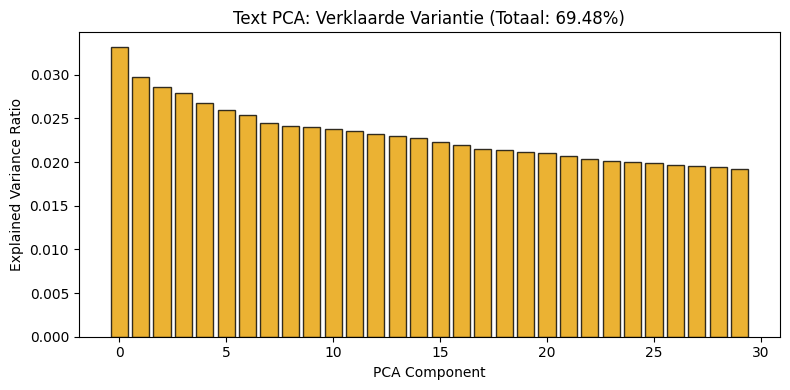

In [196]:
# Text PCA explained variance visualisatie (kleurblind-vriendelijk)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(N_TEXT_PCA), pca_text.explained_variance_ratio_, alpha=0.8, edgecolor='black', color='#E69F00')
ax.set_xlabel("PCA Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title(f"Text PCA: Verklaarde Variantie (Totaal: {pca_text.explained_variance_ratio_.sum():.2%})")
plt.tight_layout()
plt.show()

In [197]:
# Dataframe for text PCA features
text_pca_df = pd.DataFrame(
    text_features_pca,
    columns=[f"text_pca_{i}" for i in range(N_TEXT_PCA)]
)

# Final fused dataframe with image and text PCA features
final_fused_df = pd.concat(
    [
        final_fused_df.reset_index(drop=True),
        text_pca_df.reset_index(drop=True)
    ],
    axis=1
)

display(final_fused_df.sort_values(by='listeners', ascending=False).reset_index(drop=True).head())

,album_title,review_text,cover_path,listeners,playcount,gtzan_genre,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,...,img_pca_5,img_pca_6,img_pca_7,img_pca_8,img_pca_9,img_pca_10,img_pca_11,img_pca_12,img_pca_13,img_pca_14,img_pca_15,img_pca_16,img_pca_17,img_pca_18,img_pca_19,img_pca_20,img_pca_21,img_pca_22,img_pca_23,img_pca_24,text_pca_0,text_pca_1,text_pca_2,text_pca_3,text_pca_4,text_pca_5,text_pca_6,text_pca_7,text_pca_8,text_pca_9,text_pca_10,text_pca_11,text_pca_12,text_pca_13,text_pca_14,text_pca_15,text_pca_16,text_pca_17,text_pca_18,text_pca_19,text_pca_20,text_pca_21,text_pca_22,text_pca_23,text_pca_24,text_pca_25,text_pca_26,text_pca_27,text_pca_28,text_pca_29
0,Legend,Genre: Rock Label: Island Release Date: 1984 W...,album_covers\Legend.jpg,890755,15467445.0,rock,rock.00083.wav,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,...,2.982646,-2.133534,-0.292116,1.276113,2.928477,-0.629853,-2.325543,-1.982006,-0.263344,-0.776167,-0.025743,-0.383243,-1.627685,-0.674657,-2.870523,-1.377336,-0.166518,1.596195,0.532925,1.087784,-0.040691,-0.109659,0.075373,0.015258,0.315038,0.194134,-0.041493,0.105323,-0.099243,0.096924,0.038462,-0.190709,0.017426,0.125215,0.000674,-0.116280,0.168252,0.058022,0.162350,0.110375,0.115451,0.251059,-0.167770,-0.070065,0.091689,0.009050,0.246480,-0.052615,0.203451,0.346456
1,Richard D. James Album,Genre: Electronic Label: Warp Release Date: 19...,album_covers\Richard_D__James_Album.jpg,681238,16333226.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,...,-0.396934,-0.416106,0.566987,-1.292731,1.722686,-6.346733,-2.419317,-3.818710,-1.604643,0.214024,-1.628734,0.799657,-1.168959,1.751532,-2.432644,0.118172,1.345804,0.887193,-1.962616,0.146601,0.045658,0.033885,0.226994,0.019341,0.236595,0.252691,0.010936,0.113191,-0.028941,-0.128027,0.086073,0.018434,-0.188484,-0.169953,0.214789,0.238614,-0.049060,0.039956,-0.112184,0.162533,-0.053740,-0.102067,0.251134,0.007706,0.316715,0.061288,0.043182,-0.137464,0.192229,-0.191588
2,One in a Million,Genre: Pop/R&B Label: Blackground Release Date...,album_covers\One_in_a_Million.jpg,405812,6554336.0,pop,pop.00083.wav,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,...,3.569459,1.226348,-1.463242,3.719341,5.003177,5.315693,-0.742428,1.015651,1.333600,-0.067075,1.190062,-3.376432,0.3

## 4. Data Laden

### 4.1 Feature Selectie voor ML Model
We selecteren de relevante features voor het voorspellen van het aantal listeners. 

**Target variabele:** `listeners` (log-getransformeerd om scheefheid te verminderen)

**Uitgesloten kolommen:** Niet-numerieke en identificerende kolommen

In [198]:
# Target variabele voor voorspelling
target = "listeners"

# Kolommen die uitgesloten worden van features
exclude_cols = [
    "album_title", "review_text", "cover_path",
    "filename", "gtzan_genre", "listeners", "review_clean"
]

# Selecteer feature kolommen
feature_cols = [c for c in clean_df.columns if c not in exclude_cols]
X = clean_df[feature_cols].copy()

# Log-transformatie van target om scheefheid te verminderen
y = np.log1p(clean_df[target])

X.head()

,playcount,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,16333226.0,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485
1,1668.0,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803
2,617257.0,661794,0.378720,0.081298,0.101728,0.000518,2116.240550,189314.389739,2245.520378,61753.760822,4690.041555,8.228407e+05,0.092789,0.000811,0.000001,0.006299,-0.000014,0.001741,123.046875,-119.115982,1388.089844,107.419685,274.818115,-10.963199,197.215347,58.546917,58.624794,-12.912313,81.853455,26.826843,57.416031,-17.630457,51.124542,19.362967,50.797493,-15.589883,43.810387,13.559530,54.139153,-16.665264,45.890079,11.856938,34.204800,-12.183961,35.072712,5.232400,41.733974,-6.164597,40.940323,4.242698,39.739506,-8.038070,42.638783,3.521687,34.189133,-7.680920,50.981342,-1.347694,43.871803
3,283.0,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485
4,6554336.0,661504,0.298183,0.083063,0.143031,0.001971,2489.374963,551132.575507,2941.772860,207089.711778,5976.529702,3.038012e+06,0.084261,0.001629,-0.000004,0.014048,-0.000252,0.003064,123.046875,-104.421501,2083.822998,86.861282,508.588013,28.750662,351.545349,26.615248,280.706177,8.905660,237.686264,5.668197,153.511917,7.755119,96.963593,0.455965,96.432068,6.621964,77.505035,6.569269,98.753868,0.381265,86.573074,2.154854,66.411385,-0.011159,72.866234,-0.355754,68.069893,1.317084,71.488533,1.320644,57.277710,1.940723,67.537704,1.227042,78.808746,-0.118905,89.991364,0.845923,67.922485


In [ ]:
# Feature scaling met StandardScaler (Pedregosa et al., 2011)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### 4.2 ML Model Demo: Random Forest Regression
We demonstreren dat de pipeline werkt door een eenvoudig ML-model toe te passen. Random Forest Regression is een ensemble methode die meerdere decision trees combineert (Pedregosa et al., 2011).

In [ ]:
# Random Forest Regression (Pedregosa et al., 2011)
reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.3f}")

MSE: 1.38
R2: 0.889


### 4.3 Feature Importance
Visualisatie van welke features het meest bijdragen aan de voorspelling.

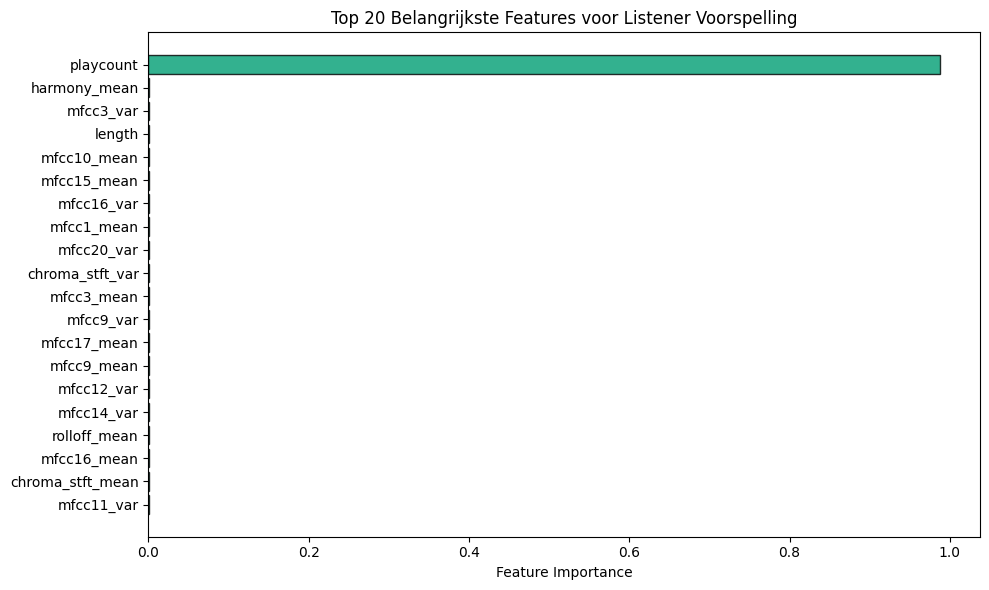


Top 20 Feature Importances:


playcount           0.988280
harmony_mean        0.000544
mfcc3_var           0.000446
length              0.000414
mfcc10_mean         0.000394
mfcc15_mean         0.000338
mfcc16_var          0.000309
mfcc1_mean          0.000302
mfcc20_var          0.000281
chroma_stft_var     0.000279
mfcc3_mean          0.000276
mfcc9_var           0.000270
mfcc17_mean         0.000268
mfcc9_mean          0.000265
mfcc12_var          0.000264
mfcc14_var          0.000251
rolloff_mean        0.000248
mfcc16_mean         0.000242
chroma_stft_mean    0.000236
mfcc11_var          0.000231
dtype: float64

In [201]:
importances = pd.Series(
    reg.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

# Top 20 feature importance visualisatie (kleurblind-vriendelijk)
fig, ax = plt.subplots(figsize=(10, 6))
top_20 = importances.head(20)
ax.barh(range(len(top_20)), top_20.values, edgecolor='black', alpha=0.8, color='#009E73')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.invert_yaxis()  # Hoogste bovenaan
ax.set_xlabel("Feature Importance")
ax.set_title("Top 20 Belangrijkste Features voor Listener Voorspelling")
plt.tight_layout()
plt.show()

print("\nTop 20 Feature Importances:")
display(importances.head(20))

### 4.3.1 Interpretatie Feature Importance

De feature importance analyse toont dat **playcount** verreweg de belangrijkste voorspeller is voor het aantal listeners (98.8%). Dit is logisch aangezien beide metrics sterk gecorreleerd zijn - albums met meer luisteraars worden ook vaker afgespeeld.

**Overige belangrijke features:**
- **Audio features** domineren de resterende importance: `harmony_mean`, diverse MFCCs (Mel-frequency cepstral coefficients), en `chroma_stft` features
- **Tekst en image PCA features** dragen minimaal bij aan de voorspelling

**Implicaties:**
- Het model leunt zwaar op de Last.fm metadata
- Voor een robuuster model zou `playcount` verwijderd kunnen worden als feature om de invloed van audio/tekst/image features beter te evalueren

## 5. Pipeline Documentatie

### 5.1 Robuustheid van de Pipeline
De pipeline is ontworpen om robuust te zijn tegen veelvoorkomende problemen:

| Scenario | Oplossing |
|----------|-----------|
| **API niet beschikbaar** | Try-except blokken met fallback waarden (0, 0, None) |
| **Webscraping structuur verandert** | Generieke selectors, meerdere fallback methodes |
| **Ontbrekende afbeeldingen** | Fallback naar zero-vector bij feature extractie |
| **Ontbrekende data** | Rijen met 0 listeners/playcount worden verwijderd |
| **Rate limiting** | time.sleep(1) tussen requests |

### 5.2 Reproduceerbaarheid
- Random states zijn gefixeerd (42) voor consistente resultaten
- Alle dependencies worden in de eerste cel geïmporteerd
- Data wordt live opgehaald bij elke run (geen lokale cache afhankelijkheid)

### 5.3 Beschrijving Final Dataframe
Het `final_fused_df` dataframe bevat de volgende kolommen:

| Kolom(men) | Type | Beschrijving |
|------------|------|--------------|
| `album_title` | str | Naam van het album |
| `review_text` | str | Originele review tekst |
| `cover_path` | str | Pad naar opgeslagen albumcover |
| `gtzan_genre` | str | Gemapte GTZAN genre categorie |
| `listeners` | int | Aantal unieke luisteraars (Last.fm) |
| `playcount` | int | Totaal aantal plays (Last.fm) |
| `filename` | str | GTZAN audio bestandsnaam |
| Audio features (60+) | float | MFCCs, spectral features, tempo, etc. |
| `img_pca_0` t/m `img_pca_15` | float | PCA-gereduceerde image features |
| `text_pca_0` t/m `text_pca_14` | float | PCA-gereduceerde text features |

**Totaal:** ~100 kolommen, klaar voor ML-toepassingen zoals:
- Regressie (voorspellen van listeners/playcount)
- Classificatie (genre voorspelling)
- Clustering (album segmentatie)

## 6. Referenties

### Wetenschappelijke Bronnen
- Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. *IEEE Transactions on Speech and Audio Processing*, 10(5), 293-302. https://ieeexplore.ieee.org/document/1021072

### Data Bronnen
- Last.fm. (2026). *Last.fm API Documentation*. https://www.last.fm/api
- Pitchfork. (2026). *Album Reviews*. https://pitchfork.com/reviews/albums/

### Libraries en Tools
- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 770-778. https://arxiv.org/abs/1512.03385
- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830. https://jmlr.org/papers/v12/pedregosa11a.html
- Richardson, L. (2023). *Beautiful Soup Documentation*. https://www.crummy.com/software/BeautifulSoup/

### AI-Assistentie
- GitHub Copilot (Claude). (2026). Gebruikt voor het genereren van docstrings, kleuren aanpassen bij visualisaties om kleurblind vriendelijk te zijn. https://github.com/features/copilot